In [1]:
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adamax
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay

from python import classes, metrics, data_loader

In [2]:
notebook_classification = ""
notebook_cv = 0

image_size = 112
batch_size = 32
total_cv = 5

max_epochs_1 = 15
lr_scheduler_patience_1 = 3
early_stopping_patience_1 = 5
max_epochs_2 = 50
lr_scheduler_patience_2 = 3
early_stopping_patience_2 = 5

data_dir = "data"
tensorboard_dir = "out/logs"
metrics_dir = "out/metrics"
models_dir = "out/keras"
weights_dir = "out/weights"
gpu_memory_limit = 1024*8

In [3]:
# Parameters
notebook_classification = "models"
notebook_cv = 1


In [4]:
assert notebook_classification in ['models', 'types'], "notebook_classification must be one of ['models', 'types']"
assert notebook_cv != 0, "notebook_cv must be provided"
assert 1 <= notebook_cv <= total_cv, "notebook_cv must be in the range [1, total_cv]"

In [5]:
class_names = classes.class_names[notebook_classification]
classes_num = len(class_names)

notebook_model = "m3"
data_dir = Path(data_dir) / f"{notebook_classification}"
tensorboard_dir = Path(tensorboard_dir) / f"{notebook_model}/{notebook_classification}/cv{notebook_cv}"
metrics_file = Path(metrics_dir) / f"{notebook_model}/{notebook_classification}.json"
model_file = Path(models_dir) / f"{notebook_model}/{notebook_classification}/cv{notebook_cv}.keras"
weights_file = Path(weights_dir) / f"{notebook_model}/{notebook_classification}/cv{notebook_cv}.weights.h5"

In [6]:
assert not model_file.is_file(), "This model already exists"

In [7]:
shutil.rmtree(tensorboard_dir, ignore_errors=True)

tensorboard_dir.mkdir(parents=True, exist_ok=True)
metrics_file.parent.mkdir(parents=True, exist_ok=True)
model_file.parent.mkdir(parents=True, exist_ok=True)
weights_file.parent.mkdir(parents=True, exist_ok=True)

In [8]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(gpus) > 0:
    tf.config.set_logical_device_configuration(gpus[0], [
        tf.config.LogicalDeviceConfiguration(memory_limit=gpu_memory_limit)
    ])

Num GPUs Available:  1


In [9]:
def gen_metrics():
    return [
        'accuracy', 
        metrics.F1Macro(classes_num), 
        metrics.PrecisionMacro(classes_num),
        metrics.RecallMacro(classes_num)
    ]

def gen_callbacks(lr_patience, es_patience):
    return [
        TensorBoard(log_dir=tensorboard_dir),
        ModelCheckpoint(weights_file, save_best_only=True, save_weights_only=True),
        ReduceLROnPlateau(monitor='val_loss', patience=lr_patience, min_lr=1e-6),
        EarlyStopping(monitor='val_loss', patience=es_patience)
    ]

In [10]:
train_data, val_data = data_loader.load_data(
    data_dir=data_dir,
    val_fold=notebook_cv,
    total_folds=total_cv,
    class_names=class_names,
    batch_size=batch_size,
    image_size=image_size
)

Found 6384 files belonging to 74 classes.

Found 6384 files belonging to 74 classes.
Found 6383 files belonging to 74 classes.


Found 6383 files belonging to 74 classes.
Found 6383 files belonging to 74 classes.


In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
])

In [12]:
base_model = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False,
    input_shape=(image_size, image_size, 3), 
    pooling='max'
)

In [13]:
# Input layer
inputs = layers.Input(shape=(image_size, image_size, 3))
x = data_augmentation(inputs)

# Base model
x = base_model(x, training=False)

# Head model
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Output layer
outputs = layers.Dense(classes_num, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         


 sequential (Sequential)     (None, 112, 112, 3)       0         


 efficientnetb3 (Functional)  (None, 1536)             10783535  


 batch_normalization (BatchN  (None, 1536)             6144      


 ormalization)                                                   


 dense (Dense)               (None, 256)               393472    


 dropout (Dropout)           (None, 256)               0         


 dense_1 (Dense)             (None, 74)                19018     


Total params: 11,202,169


Trainable params: 11,111,794


Non-trainable params: 90,375


_________________________________________________________________


In [14]:
base_model.trainable = False
model.compile(
    optimizer=Adamax(learning_rate=0.001), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=gen_metrics()
)

In [15]:
history = model.fit(
    train_data, epochs=max_epochs_1, validation_data=val_data, verbose=2,
    callbacks=gen_callbacks(lr_scheduler_patience_1, early_stopping_patience_1)
);

Epoch 1/15


800/800 - 45s - loss: 3.7083 - accuracy: 0.1420 - f1: 0.0962 - precision: 0.1119 - recall: 0.0951 - val_loss: 3.1052 - val_accuracy: 0.2395 - val_f1: 0.1772 - val_precision: 0.2238 - val_recall: 0.1742 - lr: 0.0010 - 45s/epoch - 56ms/step


Epoch 2/15


800/800 - 35s - loss: 3.1443 - accuracy: 0.2297 - f1: 0.1846 - precision: 0.2241 - recall: 0.1791 - val_loss: 2.8319 - val_accuracy: 0.2914 - val_f1: 0.2326 - val_precision: 0.2768 - val_recall: 0.2265 - lr: 0.0010 - 35s/epoch - 44ms/step


Epoch 3/15


800/800 - 36s - loss: 2.9243 - accuracy: 0.2687 - f1: 0.2273 - precision: 0.2660 - recall: 0.2179 - val_loss: 2.7167 - val_accuracy: 0.3197 - val_f1: 0.2740 - val_precision: 0.3325 - val_recall: 0.2645 - lr: 0.0010 - 36s/epoch - 45ms/step


Epoch 4/15


800/800 - 36s - loss: 2.7898 - accuracy: 0.2975 - f1: 0.2609 - precision: 0.2953 - recall: 0.2510 - val_loss: 2.6047 - val_accuracy: 0.3471 - val_f1: 0.2988 - val_precision: 0.3443 - val_recall: 0.2891 - lr: 0.0010 - 36s/epoch - 45ms/step


Epoch 5/15


800/800 - 36s - loss: 2.6870 - accuracy: 0.3204 - f1: 0.2879 - precision: 0.3335 - recall: 0.2748 - val_loss: 2.5328 - val_accuracy: 0.3551 - val_f1: 0.3166 - val_precision: 0.3980 - val_recall: 0.3041 - lr: 0.0010 - 36s/epoch - 45ms/step


Epoch 6/15


800/800 - 36s - loss: 2.6103 - accuracy: 0.3331 - f1: 0.3072 - precision: 0.3439 - recall: 0.2940 - val_loss: 2.4856 - val_accuracy: 0.3714 - val_f1: 0.3272 - val_precision: 0.3708 - val_recall: 0.3168 - lr: 0.0010 - 36s/epoch - 45ms/step


Epoch 7/15


800/800 - 36s - loss: 2.5430 - accuracy: 0.3447 - f1: 0.3185 - precision: 0.3652 - recall: 0.3054 - val_loss: 2.4399 - val_accuracy: 0.3813 - val_f1: 0.3386 - val_precision: 0.3959 - val_recall: 0.3261 - lr: 0.0010 - 36s/epoch - 45ms/step


Epoch 8/15


800/800 - 36s - loss: 2.4988 - accuracy: 0.3530 - f1: 0.3311 - precision: 0.3775 - recall: 0.3172 - val_loss: 2.4185 - val_accuracy: 0.3882 - val_f1: 0.3556 - val_precision: 0.4098 - val_recall: 0.3409 - lr: 0.0010 - 36s/epoch - 45ms/step


Epoch 9/15


800/800 - 36s - loss: 2.4447 - accuracy: 0.3694 - f1: 0.3458 - precision: 0.3898 - recall: 0.3327 - val_loss: 2.3940 - val_accuracy: 0.3885 - val_f1: 0.3528 - val_precision: 0.4124 - val_recall: 0.3401 - lr: 0.0010 - 36s/epoch - 45ms/step


Epoch 10/15


800/800 - 36s - loss: 2.4059 - accuracy: 0.3748 - f1: 0.3577 - precision: 0.4029 - recall: 0.3416 - val_loss: 2.3807 - val_accuracy: 0.3888 - val_f1: 0.3611 - val_precision: 0.4261 - val_recall: 0.3443 - lr: 0.0010 - 36s/epoch - 45ms/step


Epoch 11/15


800/800 - 36s - loss: 2.3612 - accuracy: 0.3827 - f1: 0.3635 - precision: 0.4038 - recall: 0.3502 - val_loss: 2.3626 - val_accuracy: 0.3977 - val_f1: 0.3693 - val_precision: 0.4152 - val_recall: 0.3566 - lr: 0.0010 - 36s/epoch - 46ms/step


Epoch 12/15


800/800 - 36s - loss: 2.3341 - accuracy: 0.3906 - f1: 0.3774 - precision: 0.4165 - recall: 0.3622 - val_loss: 2.3594 - val_accuracy: 0.3993 - val_f1: 0.3710 - val_precision: 0.4295 - val_recall: 0.3592 - lr: 0.0010 - 36s/epoch - 46ms/step


Epoch 13/15


800/800 - 37s - loss: 2.3023 - accuracy: 0.3979 - f1: 0.3865 - precision: 0.4251 - recall: 0.3715 - val_loss: 2.3358 - val_accuracy: 0.4034 - val_f1: 0.3738 - val_precision: 0.4288 - val_recall: 0.3601 - lr: 0.0010 - 37s/epoch - 46ms/step


Epoch 14/15


800/800 - 36s - loss: 2.2816 - accuracy: 0.4001 - f1: 0.3864 - precision: 0.4208 - recall: 0.3716 - val_loss: 2.3090 - val_accuracy: 0.4087 - val_f1: 0.3789 - val_precision: 0.4282 - val_recall: 0.3647 - lr: 0.0010 - 36s/epoch - 46ms/step


Epoch 15/15


800/800 - 37s - loss: 2.2567 - accuracy: 0.4103 - f1: 0.4037 - precision: 0.4401 - recall: 0.3866 - val_loss: 2.3128 - val_accuracy: 0.4038 - val_f1: 0.3727 - val_precision: 0.4222 - val_recall: 0.3614 - lr: 0.0010 - 37s/epoch - 46ms/step


In [16]:
model.load_weights(weights_file)
next_epoch = len(history.history['val_loss'])

In [17]:
base_model.trainable = True
model.compile(
    optimizer=Adamax(learning_rate=0.0001), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=gen_metrics()
)

In [18]:
model.fit(
    train_data, epochs=max_epochs_1+max_epochs_2, validation_data=val_data, initial_epoch=next_epoch, verbose=2,
    callbacks=gen_callbacks(lr_scheduler_patience_2, early_stopping_patience_2)
);

Epoch 16/65


800/800 - 150s - loss: 1.8700 - accuracy: 0.4979 - f1: 0.4827 - precision: 0.5269 - recall: 0.4674 - val_loss: 1.7416 - val_accuracy: 0.5410 - val_f1: 0.5067 - val_precision: 0.5597 - val_recall: 0.4906 - lr: 1.0000e-04 - 150s/epoch - 188ms/step


Epoch 17/65


800/800 - 133s - loss: 1.5529 - accuracy: 0.5743 - f1: 0.5553 - precision: 0.5873 - recall: 0.5405 - val_loss: 1.5638 - val_accuracy: 0.5832 - val_f1: 0.5497 - val_precision: 0.5866 - val_recall: 0.5370 - lr: 1.0000e-04 - 133s/epoch - 166ms/step


Epoch 18/65


800/800 - 132s - loss: 1.3550 - accuracy: 0.6252 - f1: 0.6043 - precision: 0.6373 - recall: 0.5892 - val_loss: 1.4246 - val_accuracy: 0.6227 - val_f1: 0.5905 - val_precision: 0.6378 - val_recall: 0.5734 - lr: 1.0000e-04 - 132s/epoch - 165ms/step


Epoch 19/65


800/800 - 129s - loss: 1.2117 - accuracy: 0.6640 - f1: 0.6444 - precision: 0.6760 - recall: 0.6284 - val_loss: 1.3353 - val_accuracy: 0.6405 - val_f1: 0.6083 - val_precision: 0.6617 - val_recall: 0.5910 - lr: 1.0000e-04 - 129s/epoch - 161ms/step


Epoch 20/65


800/800 - 125s - loss: 1.0922 - accuracy: 0.6939 - f1: 0.6743 - precision: 0.7045 - recall: 0.6587 - val_loss: 1.2977 - val_accuracy: 0.6534 - val_f1: 0.6234 - val_precision: 0.6967 - val_recall: 0.5986 - lr: 1.0000e-04 - 125s/epoch - 156ms/step


Epoch 21/65


800/800 - 125s - loss: 0.9834 - accuracy: 0.7233 - f1: 0.7076 - precision: 0.7357 - recall: 0.6911 - val_loss: 1.2294 - val_accuracy: 0.6732 - val_f1: 0.6485 - val_precision: 0.7045 - val_recall: 0.6260 - lr: 1.0000e-04 - 125s/epoch - 156ms/step


Epoch 22/65


800/800 - 128s - loss: 0.8755 - accuracy: 0.7520 - f1: 0.7366 - precision: 0.7597 - recall: 0.7218 - val_loss: 1.1859 - val_accuracy: 0.6853 - val_f1: 0.6635 - val_precision: 0.7210 - val_recall: 0.6412 - lr: 1.0000e-04 - 128s/epoch - 160ms/step


Epoch 23/65


800/800 - 123s - loss: 0.8039 - accuracy: 0.7725 - f1: 0.7604 - precision: 0.7865 - recall: 0.7434 - val_loss: 1.1561 - val_accuracy: 0.6972 - val_f1: 0.6719 - val_precision: 0.7322 - val_recall: 0.6449 - lr: 1.0000e-04 - 123s/epoch - 154ms/step


Epoch 24/65


800/800 - 122s - loss: 0.7210 - accuracy: 0.7924 - f1: 0.7784 - precision: 0.8007 - recall: 0.7636 - val_loss: 1.0857 - val_accuracy: 0.7138 - val_f1: 0.6888 - val_precision: 0.7294 - val_recall: 0.6716 - lr: 1.0000e-04 - 122s/epoch - 153ms/step


Epoch 25/65


800/800 - 124s - loss: 0.6603 - accuracy: 0.8094 - f1: 0.7999 - precision: 0.8159 - recall: 0.7876 - val_loss: 1.0831 - val_accuracy: 0.7191 - val_f1: 0.6960 - val_precision: 0.7438 - val_recall: 0.6728 - lr: 1.0000e-04 - 124s/epoch - 155ms/step


Epoch 26/65


800/800 - 124s - loss: 0.5907 - accuracy: 0.8301 - f1: 0.8182 - precision: 0.8329 - recall: 0.8067 - val_loss: 1.0400 - val_accuracy: 0.7301 - val_f1: 0.6969 - val_precision: 0.7375 - val_recall: 0.6787 - lr: 1.0000e-04 - 124s/epoch - 155ms/step


Epoch 27/65


800/800 - 131s - loss: 0.5337 - accuracy: 0.8446 - f1: 0.8362 - precision: 0.8463 - recall: 0.8278 - val_loss: 1.0395 - val_accuracy: 0.7351 - val_f1: 0.7116 - val_precision: 0.7518 - val_recall: 0.6925 - lr: 1.0000e-04 - 131s/epoch - 163ms/step


Epoch 28/65


800/800 - 133s - loss: 0.4896 - accuracy: 0.8596 - f1: 0.8510 - precision: 0.8620 - recall: 0.8419 - val_loss: 1.0331 - val_accuracy: 0.7387 - val_f1: 0.7109 - val_precision: 0.7559 - val_recall: 0.6886 - lr: 1.0000e-04 - 133s/epoch - 166ms/step


Epoch 29/65


800/800 - 134s - loss: 0.4332 - accuracy: 0.8766 - f1: 0.8712 - precision: 0.8836 - recall: 0.8611 - val_loss: 1.0076 - val_accuracy: 0.7469 - val_f1: 0.7166 - val_precision: 0.7571 - val_recall: 0.6987 - lr: 1.0000e-04 - 134s/epoch - 167ms/step


Epoch 30/65


800/800 - 132s - loss: 0.3869 - accuracy: 0.8888 - f1: 0.8842 - precision: 0.8919 - recall: 0.8776 - val_loss: 1.0062 - val_accuracy: 0.7478 - val_f1: 0.7218 - val_precision: 0.7668 - val_recall: 0.7000 - lr: 1.0000e-04 - 132s/epoch - 166ms/step


Epoch 31/65


800/800 - 134s - loss: 0.3490 - accuracy: 0.8979 - f1: 0.8904 - precision: 0.9016 - recall: 0.8811 - val_loss: 0.9923 - val_accuracy: 0.7560 - val_f1: 0.7306 - val_precision: 0.7700 - val_recall: 0.7105 - lr: 1.0000e-04 - 134s/epoch - 168ms/step


Epoch 32/65


800/800 - 132s - loss: 0.3213 - accuracy: 0.9069 - f1: 0.8999 - precision: 0.9061 - recall: 0.8944 - val_loss: 0.9800 - val_accuracy: 0.7570 - val_f1: 0.7291 - val_precision: 0.7682 - val_recall: 0.7093 - lr: 1.0000e-04 - 132s/epoch - 165ms/step


Epoch 33/65


800/800 - 133s - loss: 0.2887 - accuracy: 0.9158 - f1: 0.9122 - precision: 0.9197 - recall: 0.9056 - val_loss: 0.9910 - val_accuracy: 0.7638 - val_f1: 0.7403 - val_precision: 0.7851 - val_recall: 0.7203 - lr: 1.0000e-04 - 133s/epoch - 166ms/step


Epoch 34/65


800/800 - 132s - loss: 0.2604 - accuracy: 0.9260 - f1: 0.9223 - precision: 0.9290 - recall: 0.9163 - val_loss: 1.0049 - val_accuracy: 0.7574 - val_f1: 0.7320 - val_precision: 0.7818 - val_recall: 0.7103 - lr: 1.0000e-04 - 132s/epoch - 164ms/step


Epoch 35/65


800/800 - 133s - loss: 0.2284 - accuracy: 0.9349 - f1: 0.9297 - precision: 0.9362 - recall: 0.9238 - val_loss: 0.9867 - val_accuracy: 0.7644 - val_f1: 0.7399 - val_precision: 0.7773 - val_recall: 0.7233 - lr: 1.0000e-04 - 133s/epoch - 166ms/step


Epoch 36/65


800/800 - 133s - loss: 0.1904 - accuracy: 0.9460 - f1: 0.9418 - precision: 0.9461 - recall: 0.9381 - val_loss: 0.9593 - val_accuracy: 0.7724 - val_f1: 0.7470 - val_precision: 0.7853 - val_recall: 0.7294 - lr: 1.0000e-05 - 133s/epoch - 166ms/step


Epoch 37/65


800/800 - 133s - loss: 0.1796 - accuracy: 0.9496 - f1: 0.9447 - precision: 0.9486 - recall: 0.9411 - val_loss: 0.9648 - val_accuracy: 0.7711 - val_f1: 0.7428 - val_precision: 0.7802 - val_recall: 0.7259 - lr: 1.0000e-05 - 133s/epoch - 166ms/step


Epoch 38/65


800/800 - 133s - loss: 0.1715 - accuracy: 0.9541 - f1: 0.9505 - precision: 0.9551 - recall: 0.9464 - val_loss: 0.9595 - val_accuracy: 0.7749 - val_f1: 0.7466 - val_precision: 0.7831 - val_recall: 0.7297 - lr: 1.0000e-05 - 133s/epoch - 166ms/step


Epoch 39/65


800/800 - 134s - loss: 0.1667 - accuracy: 0.9546 - f1: 0.9526 - precision: 0.9574 - recall: 0.9482 - val_loss: 0.9568 - val_accuracy: 0.7762 - val_f1: 0.7458 - val_precision: 0.7840 - val_recall: 0.7287 - lr: 1.0000e-05 - 134s/epoch - 167ms/step


Epoch 40/65


800/800 - 134s - loss: 0.1696 - accuracy: 0.9539 - f1: 0.9503 - precision: 0.9550 - recall: 0.9461 - val_loss: 0.9553 - val_accuracy: 0.7769 - val_f1: 0.7481 - val_precision: 0.7827 - val_recall: 0.7320 - lr: 1.0000e-05 - 134s/epoch - 167ms/step


Epoch 41/65


800/800 - 133s - loss: 0.1642 - accuracy: 0.9567 - f1: 0.9542 - precision: 0.9584 - recall: 0.9503 - val_loss: 0.9524 - val_accuracy: 0.7771 - val_f1: 0.7498 - val_precision: 0.7859 - val_recall: 0.7325 - lr: 1.0000e-05 - 133s/epoch - 167ms/step


Epoch 42/65


800/800 - 132s - loss: 0.1613 - accuracy: 0.9568 - f1: 0.9544 - precision: 0.9577 - recall: 0.9514 - val_loss: 0.9540 - val_accuracy: 0.7755 - val_f1: 0.7467 - val_precision: 0.7838 - val_recall: 0.7298 - lr: 1.0000e-05 - 132s/epoch - 165ms/step


Epoch 43/65


800/800 - 133s - loss: 0.1563 - accuracy: 0.9579 - f1: 0.9529 - precision: 0.9577 - recall: 0.9489 - val_loss: 0.9510 - val_accuracy: 0.7782 - val_f1: 0.7504 - val_precision: 0.7892 - val_recall: 0.7323 - lr: 1.0000e-05 - 133s/epoch - 167ms/step


Epoch 44/65


800/800 - 133s - loss: 0.1512 - accuracy: 0.9597 - f1: 0.9555 - precision: 0.9601 - recall: 0.9513 - val_loss: 0.9528 - val_accuracy: 0.7782 - val_f1: 0.7492 - val_precision: 0.7879 - val_recall: 0.7313 - lr: 1.0000e-05 - 133s/epoch - 167ms/step


Epoch 45/65


800/800 - 133s - loss: 0.1512 - accuracy: 0.9586 - f1: 0.9562 - precision: 0.9610 - recall: 0.9518 - val_loss: 0.9575 - val_accuracy: 0.7751 - val_f1: 0.7466 - val_precision: 0.7868 - val_recall: 0.7283 - lr: 1.0000e-05 - 133s/epoch - 166ms/step


Epoch 46/65


800/800 - 132s - loss: 0.1448 - accuracy: 0.9621 - f1: 0.9573 - precision: 0.9600 - recall: 0.9549 - val_loss: 0.9465 - val_accuracy: 0.7791 - val_f1: 0.7523 - val_precision: 0.7891 - val_recall: 0.7349 - lr: 1.0000e-05 - 132s/epoch - 166ms/step


Epoch 47/65


800/800 - 132s - loss: 0.1425 - accuracy: 0.9626 - f1: 0.9617 - precision: 0.9651 - recall: 0.9587 - val_loss: 0.9544 - val_accuracy: 0.7782 - val_f1: 0.7520 - val_precision: 0.7865 - val_recall: 0.7367 - lr: 1.0000e-05 - 132s/epoch - 166ms/step


Epoch 48/65


800/800 - 131s - loss: 0.1460 - accuracy: 0.9611 - f1: 0.9581 - precision: 0.9635 - recall: 0.9534 - val_loss: 0.9493 - val_accuracy: 0.7793 - val_f1: 0.7503 - val_precision: 0.7885 - val_recall: 0.7334 - lr: 1.0000e-05 - 131s/epoch - 164ms/step


Epoch 49/65


800/800 - 132s - loss: 0.1431 - accuracy: 0.9622 - f1: 0.9605 - precision: 0.9651 - recall: 0.9564 - val_loss: 0.9526 - val_accuracy: 0.7810 - val_f1: 0.7549 - val_precision: 0.7914 - val_recall: 0.7387 - lr: 1.0000e-05 - 132s/epoch - 165ms/step


Epoch 50/65


800/800 - 132s - loss: 0.1342 - accuracy: 0.9655 - f1: 0.9627 - precision: 0.9667 - recall: 0.9590 - val_loss: 0.9512 - val_accuracy: 0.7813 - val_f1: 0.7549 - val_precision: 0.7898 - val_recall: 0.7396 - lr: 1.0000e-06 - 132s/epoch - 165ms/step


Epoch 51/65


800/800 - 132s - loss: 0.1384 - accuracy: 0.9633 - f1: 0.9623 - precision: 0.9648 - recall: 0.9600 - val_loss: 0.9503 - val_accuracy: 0.7818 - val_f1: 0.7544 - val_precision: 0.7894 - val_recall: 0.7391 - lr: 1.0000e-06 - 132s/epoch - 165ms/step


In [19]:
model.load_weights(weights_file)
model.save(model_file)

In [20]:
fold_metrics = metrics.evaluate_metrics(model, val_data)
metrics.save_metrics(fold_metrics, metrics_file, notebook_cv)
fold_metrics

{'f1': 0.7523449063301086,
 'precision': 0.7891084551811218,
 'recall': 0.7348684072494507}

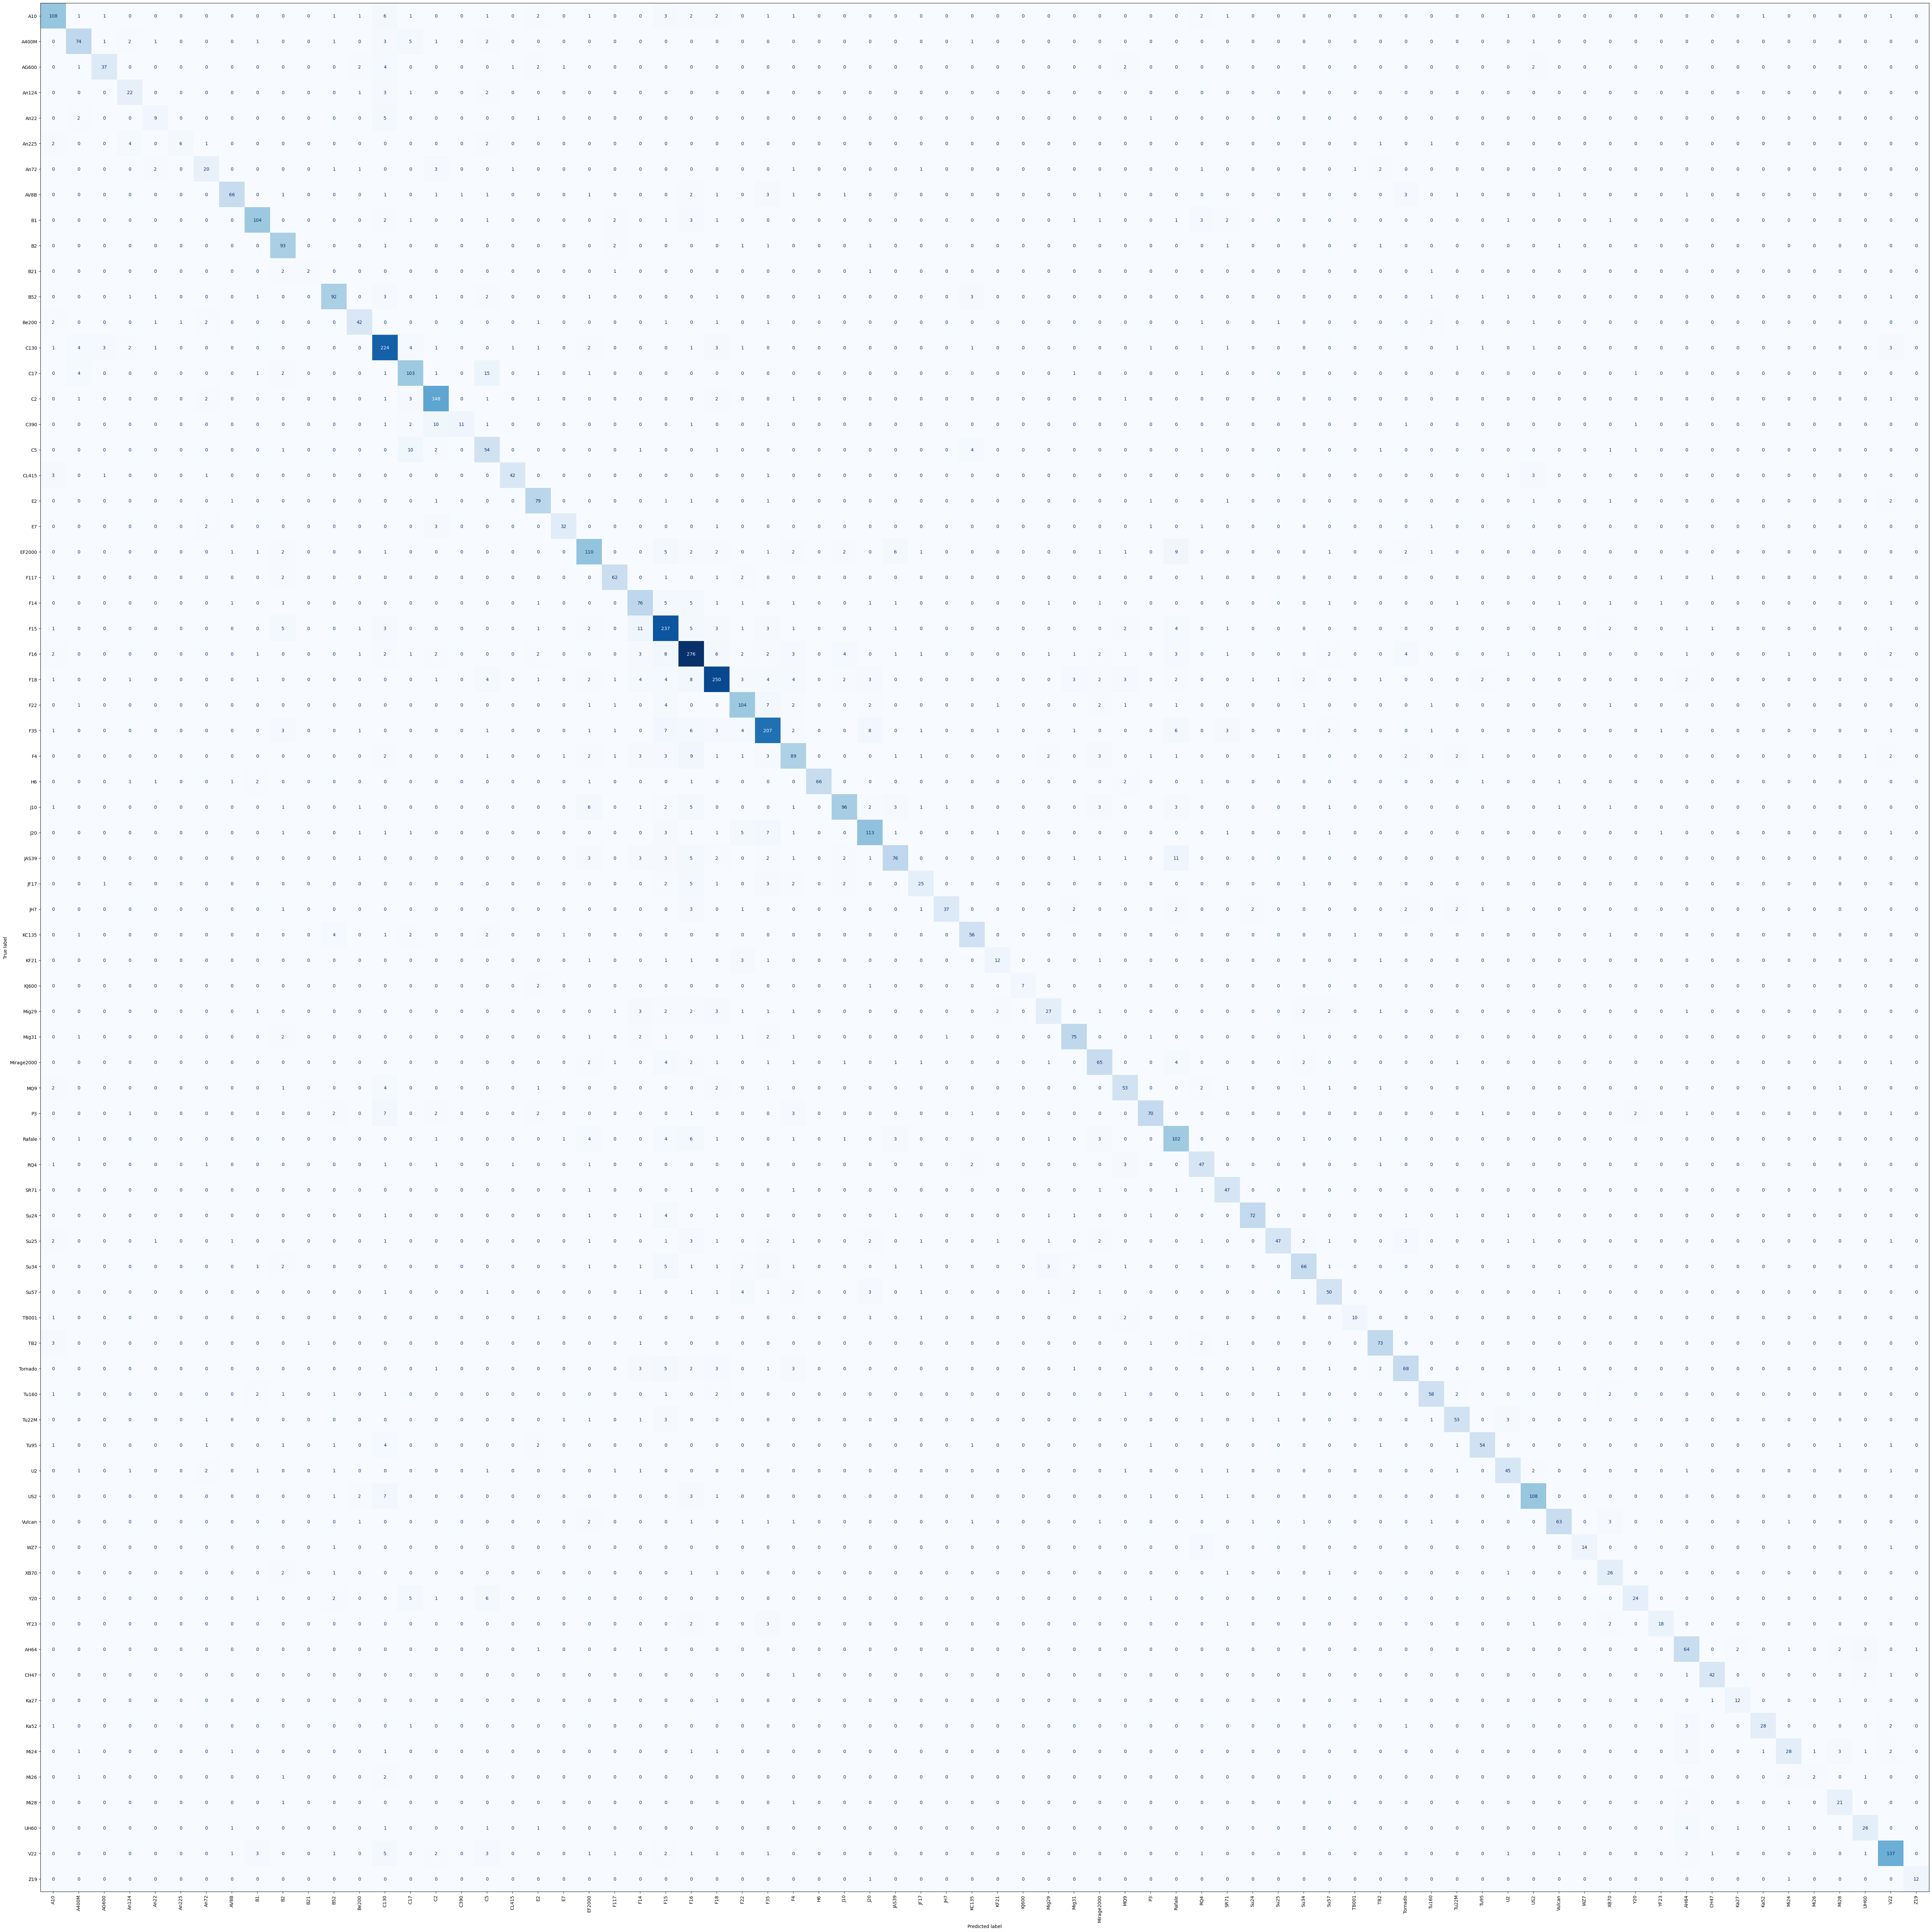

In [21]:
y_true, y_pred = metrics.model_predict(model, val_data)

fig, ax = plt.subplots(figsize=(classes_num, classes_num))
cmp = ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, 
    display_labels=class_names, 
    cmap=plt.get_cmap('Blues'),
    colorbar=False, 
    xticks_rotation='vertical', 
    ax=ax
)